# CSE 252B: Computer Vision II, Winter 2019 – Assignment 5
### Instructor: Ben Ochoa
### Due: Wednesday, March 20, 2019, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* Your code and results should remain inline in the pdf (Do not move your code to an appendix).
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Math): Point on Line Closest to the Origin (5 points)
  Given a line $\boldsymbol{l} = (a, b, c)^\top$, show that the point on
  $\boldsymbol{l}$ that is closest to the origin is the point $\boldsymbol{x} =
  (-ac, -bc, a^2+b^2)^\top$ (Hint: this calculation is needed in the
  two-view optimal triangulation method used below).

### Solution
The normal vector for the line $\boldsymbol{l}$  is $\boldsymbol{n}^T = (a,b)$. For any point $\boldsymbol{x} = (x,y,w)^T$, any other point on the normal vector $\boldsymbol{n}$ direction could be expressed as $\boldsymbol{x'} = (x+aw,y+bw,w)^T$.

Then the line that is orthogonal to the line $\boldsymbol{l}=(a,b,c)^T$ and passes through point $\boldsymbol{x}$ could be expressed as:
$$\boldsymbol{l'} = \boldsymbol{x}\times\boldsymbol{x\ '} = (-bw,aw,bx-ay)^T$$

Therefore, the point $\boldsymbol{x}_{\boldsymbol{l}}$ on line $\boldsymbol{l}$ which is closest to $\boldsymbol{x}$ is the intersection of line $\boldsymbol{l}$ and line $\boldsymbol{l'}$. And it could be calculated as:
$$\boldsymbol{x}_{\boldsymbol{l}} = \boldsymbol{l}\times\boldsymbol{l\ '} = \left[
 \begin{array}{c}
   b^2x-aby-acw \\
   a^2y-abx-bcw \\
   (a^2+b^2)w \\
 \end{array}
\right]$$

Thus, if $\boldsymbol{x} = (0,0,1)^T$ which is the origin, the point on $\boldsymbol{l}$ that is closest to the origin is the point $\boldsymbol{x}_{\boldsymbol{l}} = (-ac, -bc, a^2+b^2)^\top$



## Problem 2 (Programming): Feature Detection (20 points)
Download input data from the course website. The file IMG_5030.JPG
contains image 1 and the file IMG_5031.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 1350–1400 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features, where the detected features are indicated by a square window (the size of the detection window) about the features

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve2d as conv2d
from scipy.ndimage import convolve

def ImageGradient(I, w, t):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    #
    # outputs:
    # N is the 2x2xmxn gradient matrix
    # b in the 2x1xmxn vector used in the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    
    w = int(w/2)
    m,n = I.shape[:2]
    N = np.zeros((2,2,m,n))
    b = np.zeros((2,1,m,n))
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    
    """your code here"""
    # Change RGB to Gray
    I = np.array(Image.fromarray((I*255).astype('uint8')).convert('L'), dtype = 'float')/255.
    
    # Convolution and preparation for later calculation
    K = 1./12. * np.array([-1., 8., 0., -8., 1.])
    I_x, I_y = I.copy(), I.copy()
    I_xx, I_yy, I_xy = I.copy(),I.copy(),I.copy() # matrix for calculating Gradient matrix
    # matrix for calculating b
    x_I_xx, y_I_yy, x_I_xy, y_I_xy = I.copy(),I.copy(),I.copy(), I.copy()
    for i in range(I.shape[0]):
        I_x[i] = convolve(I[i], K, mode='reflect')
        I_xx[i] = I_x[i]*I_x[i]
    for j in range(I.shape[1]):
        I_y[:,j] = convolve(I[:,j], K, mode='reflect')
        I_yy[:,j] = I_y[:,j]*I_y[:,j]
    I_xy = I_x*I_y
    
    # reduce value smaller than e-10 to 0
    I_xx[I_xx < 10**(-20)] = 0
    I_yy[I_yy < 10**(-20)] = 0
    I_xy[I_xy < 10**(-20)] = 0
    
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            x_I_xx[i,j] = j*I_xx[i,j]
            y_I_yy[i,j] = i*I_yy[i,j]
            x_I_xy[i,j] = j*I_xy[i,j]
            y_I_xy[i,j] = i*I_xy[i,j]
    
    # Gradient Image and the b vector for corner detector
    def SingleWindow(i, j):
        g = np.zeros((2,2))
        sb = np.zeros((2,1))
        if i<w or j<w or i+w+1>m or j+w+1>n: return g, sb
        else:
            g[0][0] = I_xx[i-w:i+w+1, j-w:j+w+1].mean()
            g[1][1] = I_yy[i-w:i+w+1, j-w:j+w+1].mean()
            g[0][1] = g[1][0] = I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            sb[0,0] = x_I_xx[i-w:i+w+1, j-w:j+w+1].mean() + \
                                y_I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            sb[1,0] = y_I_yy[i-w:i+w+1, j-w:j+w+1].mean() + \
                                x_I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            return g, sb
        
    for i in range(m):
        for j in range(n):
            N[:,:,i,j], b[:,:,i,j]= SingleWindow(i,j)
    
    # Minor eigen values
    for i in range(m):
        for j in range(n):
            lam = np.min(np.linalg.eigvals(N[:,:,i,j]))
            J0[i,j] = lam
            J1[i,j] = lam if lam>=t else 0.
            
    return N, b, J0, J1
  
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w
    # For any window in J, the result should only contain 1 nonzero value
    # In the case of multiple identical maxima in the same window,
    # the tie may be broken arbitrarily
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    w_nms=int(w_nms/2)
    J2 = J.copy()
    J_tmp = J.copy()
    m,n = J.shape
    """your code here"""
    for i in range(w_nms, m-w_nms):
        for j in range(w_nms, n-w_nms):
            window = J_tmp[i-w_nms:i+w_nms+1, j-w_nms:j+w_nms+1]
            maximum = np.amax(window)   # find the maximum value in the window
            window[window<maximum]=0   # abandon those smaller than maximum value
            J2[i-w_nms:i+w_nms+1,j-w_nms: j+w_nms+1] = window.copy()
    return J2
  
  
def ForstnerCornerDetector(J, N, b):
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # J is the NMS image
    # N is the 2x2xmxn gradient matrix
    # b is the 2x1xmxn vector computed in the image_gradient function
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC list of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    
    """your code here"""
    m, n = J.shape
    C = 0
    pts = []
    for i in range(m):
        for j in range(n):
            if J[i,j]==0.: continue
            else:
                # solve for x_center, y_center
                p = np.linalg.solve(N[:,:,i,j],b[:,:,i,j]) 
                C+=1
                pts.append(p)
    pts = np.array(pts).T[0]
    return C, pts


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    N, b, J0, J1 = ImageGradient(I, w, t)
    J2 = NMS(J1, w_nms)
    C, pts = ForstnerCornerDetector(J2, N, b)
    return C, pts, J0, J1, J2


took 115.559885 secs


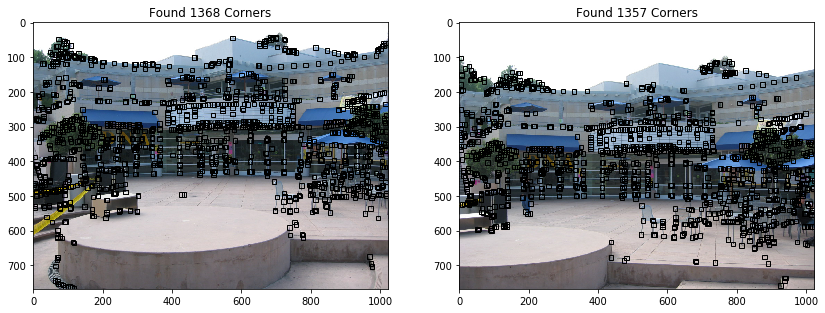

In [4]:
from PIL import Image
import time

# input images
I1 = np.array(Image.open('IMG_5030.JPG'), dtype='float')/255.
I2 = np.array(Image.open('IMG_5031.JPG'), dtype='float')/255.

# parameters to tune
w = 13
t = 0.00091
w_nms = 7

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('Found %d Corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('Found %d Corners'%C2)

plt.show()

#### Final values for parameters
* w = 13
* t = 0.00091
* w_nms = 7
* C1 = 1368
* C2 = 1357

## Problem 3 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 300 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features are indicated by a square window (the size of the matching window) about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

In [5]:
from math import *

def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    w = int(w/2)
    # Change RGB to gray
    I1 = np.array(Image.fromarray((I1*255).astype('uint8')).convert('L'), \
                  dtype = 'float')/255.
    I2 = np.array(Image.fromarray((I2*255).astype('uint8')).convert('L'), \
                  dtype = 'float')/255.
        
    # Calculation of NCC between two windows
    def ncc(w1,w2):
        w1 = np.array(w1 - w1.mean())
        w2 = np.array(w2 - w2.mean())
        corr = (w1*w2).sum() / sqrt((w1*w1).sum() * (w2*w2).sum());
        return corr

    m,n = I1.shape[:2]
    score = np.zeros((pts1.shape[1],pts2.shape[1]))
    for i in range(pts1.shape[1]):
        for j in range(pts2.shape[1]):
            x1, y1 = int((pts1[1,i])), int((pts1[0,i]))
            x2, y2 = int((pts2[1,j])), int((pts2[0,j]))
            if x1-w<0 or x2-w<0 or y1-w<0 or y2-w<0: 
                score[i,j] = -1
            elif x1+w+1>m or x2+w+1>m or y1+w+1>n or y2+w+1>n: 
                score[i,j] = -1
            elif abs(x1-x2)>p/2 or abs(y1-y2)>p/2: 
                score[i,j] = -1 # limit in the proximity window
            else:
                score[i,j] = ncc(I1[x1-w:x1+w+1,y1-w:y1+w+1],\
                                    I2[x2-w:x2+w+1,y2-w:y2+w+1])
    return score


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    
    """your code here"""
    mask = np.ones((pts1.shape[1],pts2.shape[1]))
    
    pair1 = []
    pair2 = []
    temp_scores = np.multiply(mask,scores)
    while t<np.max(temp_scores):
        max_index = np.argmax(temp_scores)
        max_corr = np.max(temp_scores)
        row = int(max_index/pts2.shape[1])
        col = int(max_index%pts2.shape[1])
        scores[row,col] = -1
        max_next = max([scores[row,:].max(),scores[:,col].max()])
        scores[row,col] = max_corr
        if (1-scores[row,col])<((1-max_next)*d):
            pair1.append(row)
            pair2.append(col)
        mask[row,:] = np.zeros((1,pts2.shape[1]))
        mask[:,col] = np.zeros((1,pts1.shape[1]))
        temp_scores = np.multiply(mask,temp_scores)
    
    inds = np.array([pair1,pair2])
    
    return inds



def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p=0):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d) 
    return inds


took 20.829286 secs


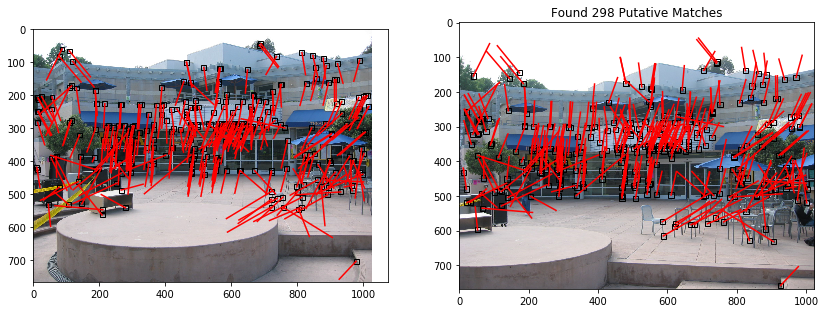

unique points in image 1: 298
unique points in image 2: 298


In [6]:
# parameters to tune
w = 15
t = 0.5
d = 0.88
p = 300

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:]]
match2 = pts2[:,inds[1,:]]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('Found %d Putative Matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 15
* t = 0.5
* d = 0.88
* p = 300
* num_matches = 298

## Problem 4 (Programming): Outlier Rejection (20 points)
  
  The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 7-point algorithm (as described in
lecture) to estimate the fundamental matrix, resulting in 1 or 3 solutions. Calculate 
the (squared) Sampson error as a first order approximation to the geometric error.

Hint: this problem has codimension 1

Also: fix a random seed in your MSAC. If I cannot reproduce your results, you will lose points.

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 * random seed
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

took 0.604383 secs
36 iterations
inlier count:  222
inliers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 110, 111, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 148, 149, 151, 152, 153, 154, 155, 156, 159, 161, 162, 163, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 179, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 222, 223, 224, 225, 228, 229, 231, 232, 233, 235, 236, 238, 240, 241, 242, 243, 244, 250, 251, 252, 25

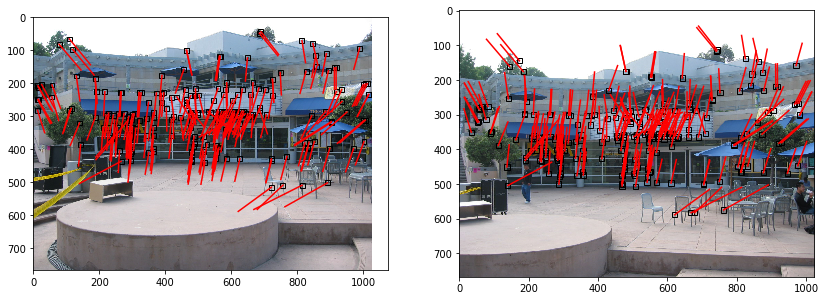

In [7]:
from scipy.stats import chi2
import random
random.seed(a=500000)
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    """your code here"""
    n, m = pts.shape[0], pts.shape[1]
    u = [x.mean() for x in pts] # mean values of each dimensino
    d = [(np.std(x))**2 for x in pts] # deviation of each dimensino
    s = (n/sum(d))**0.5  # scale
    T = np.eye(n+1)
    T[:n, :n] = np.eye(n)*s
    T[:n,-1] = np.array(u)*(-1)*s  # Transform matrix
    pts = Homogenize(pts) 
    pts = np.array([T*np.mat(pts[:,i]).T for i in range(m)])
    pts = pts.reshape(m,n+1).T
    return pts, T

def nullspace(A, d):
    _, _, V = np.linalg.svd(A)
    ns = V[-d:,:].T
    return ns
def Fundamental(pts1, pts2, samples):
    a1 = np.kron(Homogenize(pts2[:,samples[0]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[0]].reshape(2,1)).T)
    a2 = np.kron(Homogenize(pts2[:,samples[1]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[1]].reshape(2,1)).T)
    a3 = np.kron(Homogenize(pts2[:,samples[2]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[2]].reshape(2,1)).T)
    a4 = np.kron(Homogenize(pts2[:,samples[3]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[3]].reshape(2,1)).T)
    a5 = np.kron(Homogenize(pts2[:,samples[4]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[4]].reshape(2,1)).T)
    a6 = np.kron(Homogenize(pts2[:,samples[5]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[5]].reshape(2,1)).T)
    a7 = np.kron(Homogenize(pts2[:,samples[6]].reshape(2,1)).T,\
                 Homogenize(pts1[:,samples[6]].reshape(2,1)).T)
    
    A = np.vstack((a1,a2,a3,a4,a5,a6,a7))
    ns = nullspace(A,2)
    F1 = ns[:,0].reshape(3,3)
    F2 = ns[:,1].reshape(3,3)
    G = ns[0,0]*ns[4,0]*ns[8,0] - ns[0,0]*ns[5,0]*ns[7,0] - ns[1,0]*ns[3,0]*ns[8,0] \
        + ns[1,0]*ns[5,0]*ns[6,0] + ns[2,0]*ns[3,0]*ns[7,0] - ns[2,0]*ns[4,0]*ns[6,0]
    H = ns[0,0]*ns[4,0]*ns[8,1] - ns[0,0]*ns[5,0]*ns[7,1] - ns[0,0]*ns[7,0]*ns[5,1] \
        + ns[0,0]*ns[8,0]*ns[4,1] - ns[1,0]*ns[3,0]*ns[8,1] + ns[1,0]*ns[5,0]*ns[6,1] \
        + ns[1,0]*ns[6,0]*ns[5,1] - ns[1,0]*ns[8,0]*ns[3,1] + ns[2,0]*ns[3,0]*ns[7,1] \
        - ns[2,0]*ns[4,0]*ns[6,1] - ns[2,0]*ns[6,0]*ns[4,1] + ns[2,0]*ns[7,0]*ns[3,1] \
        + ns[3,0]*ns[7,0]*ns[2,1] - ns[3,0]*ns[8,0]*ns[1,1] - ns[4,0]*ns[6,0]*ns[2,1] \
        + ns[4,0]*ns[8,0]*ns[0,1] + ns[5,0]*ns[6,0]*ns[1,1] - ns[5,0]*ns[7,0]*ns[0,1]
    I = ns[0,0]*ns[4,1]*ns[8,1] - ns[0,0]*ns[5,1]*ns[7,1] - ns[1,0]*ns[3,1]*ns[8,1] \
        + ns[1,0]*ns[5,1]*ns[6,1] + ns[2,0]*ns[3,1]*ns[7,1] - ns[2,0]*ns[4,1]*ns[6,1] \
        - ns[3,0]*ns[1,1]*ns[8,1] + ns[3,0]*ns[2,1]*ns[7,1] + ns[4,0]*ns[0,1]*ns[8,1] \
        - ns[4,0]*ns[2,1]*ns[6,1] - ns[5,0]*ns[0,1]*ns[7,1] + ns[5,0]*ns[1,1]*ns[6,1] \
        + ns[6,0]*ns[1,1]*ns[5,1] - ns[6,0]*ns[2,1]*ns[4,1] - ns[7,0]*ns[0,1]*ns[5,1] \
        + ns[7,0]*ns[2,1]*ns[3,1] + ns[8,0]*ns[0,1]*ns[4,1] - ns[8,0]*ns[1,1]*ns[3,1]
    J = ns[0,1]*ns[4,1]*ns[8,1] - ns[0,1]*ns[5,1]*ns[7,1] - ns[1,1]*ns[3,1]*ns[8,1] \
        + ns[1,1]*ns[5,1]*ns[6,1] + ns[2,1]*ns[3,1]*ns[7,1] - ns[2,1]*ns[4,1]*ns[6,1]
    alpha = np.roots(np.array([G,H,I,J]).reshape(4))
    alpha = np.real(alpha[np.isreal(alpha)])
    
    F = []
    for alpha_t in alpha:
        F.append(alpha_t*F1+F2)
    return F

# checked
def Sampson_error(pts1, pts2, F):
    error_vec = []
    Sampson_vec = []
    for i in range(pts1.shape[1]):
        x1 = pts1[0,i]
        x2 = pts2[0,i]
        y1 = pts1[1,i]
        y2 = pts2[1,i]
        
        A = np.kron(Homogenize(pts2[:,i].reshape(2,1)).T,\
                    Homogenize(pts1[:,i].reshape(2,1)).T)
        f = np.vstack((F[0,:].reshape(3,1),F[1,:].reshape(3,1),F[2,:].reshape(3,1)))
        epsil = A.dot(f)
        J = np.array([x2*F[0,0]+y2*F[1,0]+F[2,0],\
                      x2*F[0,1]+y2*F[1,1]+F[2,1],\
                      x1*F[0,0]+y1*F[0,1]+F[0,2],\
                      x1*F[1,0]+y1*F[1,1]+F[1,2]]).reshape(1,-1)
        lam = -1.0*epsil/(J.dot(J.T))
        delta = J.T*lam
        Sampson_vec.append(delta)
        error = delta.T.dot(delta)
        error_vec.append(error)
    return error_vec,np.array(Sampson_vec).reshape(pts1.shape[1],delta.shape[0]).T

# checked
def consensus_cost(error,tol):
    cost = 0
    num_inlier = 0
    inliers = []
    for i in range(len(error)):
        if error[i]<=tol:
            cost = cost+error[i]
            num_inlier = num_inlier+1
            inliers.append(i)
        else:
            cost = cost+tol
    return cost,num_inlier,inliers

def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - fundamental matrix F
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    """your code here"""
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    while trials < max_trials and consensus_min_cost>thresh:
        samples = random.sample(range(pts1.shape[1]),7)
        F = Fundamental(pts1, pts2, samples)
        for f in F:
            error,Sampson_vec = Sampson_error(pts1, pts2, f)
            cost,num_inlier,inliers = consensus_cost(error,tol)
            if cost<consensus_min_cost:
                consensus_min_cost = cost
                consensus_min_cost_model = f
                # update max_trials
                ww = float(num_inlier)/float(pts1.shape[1])
                if ww>0:
                    max_trials = np.log(1-p)/np.log(1-ww**7)  
            trials = trials+1
    
    error,Sampson_vec = Sampson_error(pts1, pts2, consensus_min_cost_model)
    consensus_min_cost,num_inlier,inliers = consensus_cost(error,tol)
    consensus_min_cost_model/=np.linalg.norm(consensus_min_cost_model)
    return consensus_min_cost, consensus_min_cost_model, inliers, trials

# MSAC parameters 
thresh = 0
tol = 3.8415
p = 0.99
alpha = 0.95

tic=time.time()

cost_MSAC, F_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
x1 = match1[:,inliers]
x2 = match2[:,inliers]
outliers = np.setdiff1d(np.arange(match1.shape[1]),inliers)
toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost = %.9f'%cost_MSAC)
print('F_MSAC = ')
print(F_MSAC)

# display the figures
"""your code here"""
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
for i in range(x1.shape[1]):
    ii = inds[0,inliers[i]]
    jj = inds[1,inliers[i]]
    x1_x, x1_y = pts1[0,ii], pts1[1,ii]
    x2_x, x2_y = pts2[0,jj], pts2[1,jj]
    ax1.plot([x1_x, x2_x],[x1_y, x2_y],'-r')
    ax1.add_patch(patches.Rectangle((x1_x-w/2,x1_y-w/2),w,w, fill=False))
    ax2.plot([x2_x, x1_x],[x2_y, x1_y],'-r')
    ax2.add_patch(patches.Rectangle((x2_x-w/2,x2_y-w/2),w,w, fill=False))
plt.show()

#### Final values for parameters
* random seed = 500000
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 3.8415
* threshold = 0
* num_inliers = 222
* num_attempts = 36
* consensus_min_cost = 402.592944352

## Problem 5 (Programming): Linear Estimation of the Fundamental Matrix (15 points)
  Estimate the fundamental matrix $\boldsymbol{F}_\text{DLT}$ from the
  resulting set of inlier correspondences using the direct linear
  transformation (DLT) algorithm (with data normalization).  Include
  the numerical values of the resulting $\boldsymbol{F}_\text{DLT}$, scaled
  such that $||\boldsymbol{F}_\text{DLT}||_\text{Fro} = 1$

In [8]:
def Sinc(x):
    if x==0: 
        y=1
    else: 
        y = np.sin(x)/float(x)
    return y

def dSinc(x):
    # Returns a scalar valued sinc value
    if x==0: y=0
    else: y = np.cos(x)/x - np.sin(x)/(x**2)
    return y

def Parameterization(v):
    v = v/np.linalg.norm(v)
    a = v[0,0]
    b = v[1:]
    v_i = 2.0/Sinc(np.arccos(a))*b
    
    if np.linalg.norm(v_i)>np.pi:
        v_i = (1-2.0*np.pi/np.linalg.norm(v_i)*\
               np.ceil((np.linalg.norm(v_i)-np.pi)/(2.0*np.pi)))*v_i
    return v_i.reshape(b.shape[0],1)

def Deparameterization(v):
    if np.linalg.norm(v)>np.pi:
        v = (1-2.0*np.pi/np.linalg.norm(v)*\
             np.ceil((np.linalg.norm(v)-np.pi)/(2.0*np.pi)))*v
    a = np.cos(np.linalg.norm(v)/2.0)
    b = Sinc(np.linalg.norm(v)/2.0)/2.0*v
    return np.vstack((a,b))

def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    F - the DLT estimate of the fundamental matrix  
    
    """your code here"""
    
    # data normalization
    x1_normalized_homo,T = Normalize(x1)
    x2_normalized_homo,U = Normalize(x2)
    x1_normalized = Dehomogenize(x1_normalized_homo)
    x2_normalized = Dehomogenize(x2_normalized_homo)
    
    A = np.zeros((1,9))
    for i in range(x1.shape[1]):
        A = np.vstack((A,np.kron(Homogenize(x2_normalized[:,i].reshape(2,1)).T,\
                                 Homogenize(x1_normalized[:,i].reshape(2,1)).T)))
    U_svd, s, V = np.linalg.svd(A[1:,:], full_matrices=False)
    F = np.array([V[8,0:3],V[8,3:6],V[8,6:]])
    U_svd, s, V = np.linalg.svd(F, full_matrices=False)
    s[2] = 0
    F = U_svd.dot(np.diag(s)).dot(V)
    F = U.T.dot(F).dot(T)
    
    error,Sampson_vec = Sampson_error(x1, x2, F)
    return F/np.linalg.norm(F)


# compute the linear estimate with data normalization
print ('DLT with Data Normalization')
time_start=time.time()
F_DLT = DLT(x1, x2, normalize=True)
time_total=time.time()-time_start

# display the resulting F_DLT, scaled with its frobenius norm
print('F_DLT =')
print(F_DLT)

DLT with Data Normalization
F_DLT =
[[-2.01182575e-08 -4.99770024e-07  4.03130888e-04]
 [-4.22072068e-07 -3.03486150e-07  1.11679993e-02]
 [-6.55035679e-05 -1.03135011e-02 -9.99884364e-01]]


## Problem 6 (Programming): Nonlinear Estimation of the Fundamental Matrix (70 points) 
  Retrieve the camera projection matrices $\boldsymbol{P} = [\boldsymbol{I} \,|\,
  \boldsymbol{0}]$ and $\boldsymbol{P}' = [\boldsymbol{M} \,|\, \boldsymbol{v}]$, where $\boldsymbol{M}$
  is full rank, from $\boldsymbol{F}_\text{DLT}$.  Use the resulting camera
  projection matrix $\boldsymbol{P}'$ associated with the second image and
  the triangulated 3D points as an initial estimate to an iterative
  estimation method, specifically the sparse Levenberg-Marquardt
  algorithm, to determine the Maximum Likelihood estimate of the
  fundamental matrix $\boldsymbol{F} = [\boldsymbol{v}]_\times \boldsymbol{M}$ that
  minimizes the reprojection error.  The initial estimate of the 3D
  points must be determined using the two-view optimal triangulation
  method described in lecture (algorithm 12.1 in the Hartley \&
  Zisserman book, but use the ray-plane intersection method for the
  final step instead of the homogeneous method).  Additionally, you
  must parameterize the camera projection matrix $\boldsymbol{P}'$ associated
  with the second image and the homogeneous 3D scene points that are
  being adjusted using the parameterization of homogeneous vectors
  (see section A6.9.2 (page 624) of the textbook, and the corrections
  and errata).
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the fundamental matrix $\boldsymbol{F}_\text{LM}$, scaled
  such that $||\boldsymbol{F}_\text{LM}||_\text{Fro} = 1$.

In [9]:
from scipy.linalg import block_diag

# checked
def ProjFromFund(F):
    W = np.zeros((3,3))
    Z = np.zeros((3,3))
    W[0,1] = 1
    W[1,0] = -1
    Z[0,1] = -1
    Z[1,0] = 1
    Z[2,2] = 1
    
    U, D, V = np.linalg.svd(F, full_matrices=False)
    D[2] = (D[0]+D[1])/2.0
    S = U.dot(W).dot(U.T)
    M = U.dot(Z).dot(np.diag(D)).dot(V)
    e = np.zeros((3,1))
    e[0,0] = S[2,1]
    e[1,0] = S[0,2]
    e[2,0] = S[1,0]
    P = np.hstack((M,e))
    return P

#checked
def FundFromProj(P):
    M = P[:,:3]
    e = P[:,3].reshape(3,1)
    e_x = np.zeros((3,3))
    e_x[0,1] = -e[2,0]
    e_x[1,0] = e[2,0]
    e_x[0,2] = e[1,0]
    e_x[2,0] = -e[1,0]
    e_x[1,2] = -e[0,0]
    e_x[2,1] = e[0,0]
    F = e_x.dot(M)
    return F

#checked
def epipole(F):
    U, D, V = np.linalg.svd(F, full_matrices=False)
    e = V[-1,:].reshape(3,1)
    U, D, V = np.linalg.svd(F.T, full_matrices=False)
    e_prime = V[-1,:].reshape(3,1)
    
    # scale
    e = e/np.sqrt(e[0,0]**2+e[1,0]**2)
    e_prime = e_prime/np.sqrt(e_prime[0,0]**2+e_prime[1,0]**2)
    return e, e_prime

# checked
def select_t(t,a,b,c,d,f,f_prime):
    t_best = 0
    cost_best = np.inf
    for tt in t:
        cost = tt**2/(1.0+f**2*tt**2)+(c*tt+d)**2/((a*tt+b)**2+f_prime**2*(c*tt+d)**2)
        if cost<cost_best:
            cost_best = cost
            t_best = tt
    # for t = inf
    cost = 1.0/(f**2)+c**2/(a**2+f_prime**2*c**2)
    if cost<cost_best:
        cost_best = cost
        t_best = np.inf
    return t_best

# checked
def correct_pts(a,b,c,d,f,f_prime):
    # Form polynomial and solve for t
    A = -(a*d-b*c)*a*c*(f**4)
    B = (a**2+(c**2)*(f_prime**2))**2-(a*d-b*c)*(a*d+b*c)*(f**4)
    C = 4*(a**2 + (c*f_prime)**2)*(c*d*f_prime+a*b) - \
        (a*d-b*c)*(b*d*(f**4)-2*a*c*(f**2))
    D = 2*(a**2 + (c**2)*(f_prime**2))*(b**2 + (d**2)*(f_prime**2)) + \
        4*(c*d*(f_prime**2) + a*b)**2 + (a*d - b*c)*2*f*(a*d + b*c)
#     E = 2*(b**2 + d**2*f_prime**2)*(2*c*d*f_prime**2 + 2*a*b) - a*c*(a*d - b*c) - 2*b*d*f**2*(a*d - b*c)
    E = 4*(b**2 + (d**2)*(f_prime**2))*(c*d*(f_prime**2) + a*b) + \
        (a*d - b*c)*(2*b*d*(f**2)-a*c)
    F = (b**2 + (d**2)*(f_prime**2))**2 -(a*d - b*c)*(a*d + b*c)
    G = - b*d*(a*d - b*c)
    t = np.roots(np.array([A,B,C,D,E,F,G]).reshape(7))
    t = np.real(t)
    
    # select t
    t_best = select_t(t,a,b,c,d,f,f_prime)
    
    # form line l, l'
    if t_best == np.inf:
        l = np.array([f,0,-1])
        l_prime = np.array([-f_prime*c,a,c])
    else:
        l = np.array([t_best*f,1,-t_best])
        l_prime = np.array([-f_prime*(c*t_best+d),a*t_best+b,c*t_best+d])
    
    # determine x and x_prime, see Problem 1
    x = np.array([-l[0]*l[2],-l[1]*l[2],l[0]**2+l[1]**2]).reshape(3,1)
    x_prime = np.array([-l_prime[0]*l_prime[2],-l_prime[1]*l_prime[2],\
                        l_prime[0]**2+l_prime[1]**2]).reshape(3,1)
    return x, x_prime

# to check
def triangulation(pts1, pts2, F, P):
    # Input:
    # pts1, pts2 - inhomogeneous 2D image points
    # F - fundamental matrix
    # P - projection matrix of camera 2
    
    pts1 = Homogenize(pts1)
    pts2 = Homogenize(pts2)
    T = pts1[2,0]*np.eye(3)
    T_prime = pts2[2,0]*np.eye(3)
    T[0,2] = -pts1[0,0]
    T[1,2] = -pts1[1,0]
    T_prime[0,2] = -pts2[0,0]
    T_prime[1,2] = -pts2[1,0]
    # epipoles
    Fs = (np.linalg.inv(T_prime).T).dot(F).dot(np.linalg.inv(T))
    e, e_prime = epipole(Fs) # already scaled
    
    # Form rotation matrix
    R = np.zeros((3,3))
    R[0,0] = e[0,0]
    R[1,1] = e[0,0]
    R[0,1] = e[1,0]
    R[1,0] = -e[1,0]
    R[2,2] = 1
    R_prime = np.zeros((3,3))
    R_prime[0,0] = e_prime[0,0]
    R_prime[1,1] = e_prime[0,0]
    R_prime[0,1] = e_prime[1,0]
    R_prime[1,0] = -e_prime[1,0]
    R_prime[2,2] = 1
    Fs = R_prime.dot(Fs).dot(R.T)
    
    # Form the polynomial g(t)'s parameters
    a = Fs[1,1]
    b = Fs[1,2]
    c = Fs[2,1]
    d = Fs[2,2]
    f = e[2,0]
    f_prime = e_prime[2,0]

    # Correct points
    x, x_prime = correct_pts(a,b,c,d,f,f_prime)
    pts1_corrected = np.linalg.inv(T).dot(R.T).dot(x)
    pts2_corrected = np.linalg.inv(T_prime).dot(R_prime.T).dot(x_prime)
    
    # 2-view triangulation
    l_prime = F.dot(pts1_corrected)
    l_prime_orthog = np.array([-l_prime[1,0]*pts2_corrected[2,0],l_prime[0,0]*pts2_corrected[2,0],\
                    l_prime[1,0]*pts2_corrected[0,0]-l_prime[0,0]*pts2_corrected[1,0]]).reshape(3,1)
    plane_pi = P.T.dot(l_prime_orthog) # backproject orthogonal line to plane
    P = np.hstack((np.eye(3),np.zeros((3,1))))
    # backproject x to 3D line using canonical camera
#     P_pseudoinv = np.vstack((np.eye(3),np.zeros((1,3))))
#     X = P_pseudoinv.dot(pts1_corrected)
#     # intersection of line and plane
#     X_pi = np.array([plane_pi[3,0]*X[0,0],plane_pi[3,0]*X[1,0],plane_pi[3,0]*X[2,0],\
#                     -(plane_pi[0,0]*X[0,0]+plane_pi[1,0]*X[1,0]+plane_pi[2,0]*X[2,0])]).reshape(4,1)
    a,b,c,d = plane_pi[0,0], plane_pi[1,0], plane_pi[2,0], plane_pi[3,0]
    C = nullspace(P, 1)
    P_pseudoinv = P.T.dot(np.linalg.inv(P.dot(P.T)))
    X = P_pseudoinv.dot(pts1_corrected)
    X1, Y1, Z1, T1 = C[0,0], C[1,0], C[2,0], C[3,0]
    X2, Y2, Z2, T2 = X[0,0], X[1,0], X[2,0], X[3,0]
    X_pi = np.array([X2*(b*Y1+c*Z1+d*T1)-X1*(b*Y2+c*Z2+d*T2), \
                     Y2*(a*X1+c*Z1+d*T1)-Y1*(a*X2+c*Z2+d*T2),\
                     Z2*(a*X1+b*Y1+d*T1)-Z1*(a*X2+b*Y2+d*T2), \
                     T2*(b*Y1+c*Z1+a*X1)-T1*(b*Y2+c*Z2+a*X2)]).reshape(4,1)
    return Dehomogenize(X_pi)

In [17]:
def LM_cost(P,pts1,pts2,X):
    P1 = np.hstack((np.eye(3),np.zeros((3,1))))
    P2 = P
    diff1 = x1 - Dehomogenize(P1.dot(Homogenize(X)))
    diff2 = pts2 - Dehomogenize(P2.dot(Homogenize(X)))
    cost = np.trace(diff1.T.dot(diff1)) + np.trace(diff2.T.dot(diff2))
    return cost

def Projection(X,P):
    return Dehomogenize(P.dot(Homogenize(X)))

# checked
def Parameterization_prime(p):
    n = p.shape[0]
    p_para = np.zeros((n+1,n))
    p_norm = np.linalg.norm(p)
    b = Sinc(p_norm/2.0)/2.0*p
    if np.linalg.norm(p) == 0:
        p_para[1:,:] = 0.5 * np.eye(n)
    else:
        p_para[0,:] = -1.0/2*b.T
        p_para[1:,:] = Sinc(p_norm/2.0)/2.0*np.eye(n) \
                + 1.0/(4.0*p_norm) * dSinc(p_norm/2.0)* (np.mat(p).T * np.mat(p))
    return p_para

# checked
def derivative_xprime_p(x,X,P):
    X = Homogenize(X)
    w = P[2,:].reshape(1,4).dot(X)
    xprime_p = 1.0/w*np.array([[X[0,0],X[1,0],X[2,0],X[3,0],0,0,0,0,\
                                -x[0,0]*X[0,0],-x[0,0]*X[1,0],\
                                -x[0,0]*X[2,0],-x[0,0]*X[3,0]],\
                                 [0,0,0,0,X[0,0],X[1,0],X[2,0],X[3,0],\
                                -x[1,0]*X[0,0],-x[1,0]*X[1,0],\
                                -x[1,0]*X[2,0],-x[1,0]*X[3,0]]])
    return xprime_p

# checked
def derivative_xprime_X(x,X,P):
    X = Homogenize(X)
    w = P[2,:].reshape(1,4).dot(X)
    xprime_X = 1.0/w*np.array([[P[0,0]-x[0,0]*P[2,0],\
                                P[0,1]-x[0,0]*P[2,1],\
                                P[0,2]-x[0,0]*P[2,2],\
                                P[0,3]-x[0,0]*P[2,3]],\
                               [P[1,0]-x[1,0]*P[2,0],\
                                P[1,1]-x[1,0]*P[2,1],\
                                P[1,2]-x[1,0]*P[2,2],\
                                P[1,3]-x[1,0]*P[2,3]]])
    return xprime_X

# checked
def Jacobian(pts1,pts2,X,P1,P2):
    # Input:
    # pts1, pts2 - normalized inhomogeneous 2D image point
    # X - normalized inhomogeneous reprojected 3D points
    # P1 - projective matrix of canonical camera (camera 1)
    # P2 - projective matrix of general camera (camera 2)
    p = Parameterization(P2.reshape(-1,1))
    A = derivative_xprime_p(pts2,X,P2).dot(Parameterization_prime(p))
    
    X_para = Parameterization(Homogenize(X))
    v = Parameterization_prime(X_para)
    B = derivative_xprime_X(pts1,X,P1).dot(v)
    B_prime = derivative_xprime_X(pts2,X,P2).dot(v)
    
    return A,B,B_prime

# checked
def init_3Dpts(pts1, pts2, F):
    P = ProjFromFund(F)
    X_vec = []
    for i in range(pts1.shape[1]):
        X = triangulation(pts1[:,i].reshape(2,1), pts2[:,i].reshape(2,1), F, P)
        X_vec.append(X)
    return np.array(X_vec).reshape(-1,3).T

def LM(F, x1, x2, max_iters, lam):
    # Input:
    #    F - DLT estimate of the fundamental matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    F - Final fundamental matrix obtained after convergence
    
    """your code here"""
    X = init_3Dpts(x1, x2, F)
    P = ProjFromFund(F)
    cost = LM_cost(P,x1,x2,X)
    print ('iter %03d Cost %.12f'%(0, cost))
    
    #Data Normalization
    x1_normalized_homo,T = Normalize(x1)
    x2_normalized_homo,N = Normalize(x2)
    X_normalized_homo,Hs = Normalize(X)
    s_1 = T[0,0]**2
    s_2 = N[0,0]**2
    sigma_1 = s_1*np.eye(2)
    sigma_2 = s_2*np.eye(2)
    
    #Normalize P
    P_prime = P.copy()
    P_prime = N.dot(P_prime).dot(np.linalg.inv(Hs)) 
#     P_prime = P_prime/np.linalg.norm(P_prime)
    P_canonic = T.dot(np.hstack((np.eye(3),np.zeros((3,1))))).dot(np.linalg.inv(Hs))

    # Parameter vector and measurement vector
    x1_normalized = Dehomogenize(x1_normalized_homo)
    x2_normalized = Dehomogenize(x2_normalized_homo)
    X_normalized = Dehomogenize(X_normalized_homo)
    p = P_prime.reshape(-1,1)
    p_para = Parameterization(p)
        
    #LM step
    flag = True
    iter_num = 0
    count = 0
    # initial epsilon
    for i in range(x1.shape[1]):
        epsil_i = x1_normalized[:,i].reshape(2,1) - \
                    Projection(X_normalized[:,i].reshape(3,1),P_canonic)
        epsil_i_prime = x2_normalized[:,i].reshape(2,1) - \
                        Projection(X_normalized[:,i].reshape(3,1),P_prime)
    # loops
    control = 0
    while (flag and iter_num<max_iters):
        control+=1
        # Jacobin Matrix and Normal Equation Matrix
        U = np.zeros((11,11))
        epsil_a_prime = np.zeros((11,1))
        V_i = []
        W_i = []
        epsil_bi = []
        for i in range(x1.shape[1]):
            A,B,B_prime = Jacobian(x1_normalized[:,i].reshape(2,1), x2_normalized[:,i].reshape(2,1),\
                                   X_normalized[:,i].reshape(3,1), P_canonic, P_prime)
            
            U = U + A.T.dot(np.linalg.inv(sigma_2)).dot(A)
            V_i.append(B.T.dot(np.linalg.inv(sigma_1)).dot(B) + \
                       B_prime.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
            W_i.append(A.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
            
            epsil_a_prime = epsil_a_prime + A.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime)
            epsil_bi.append(B.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i) \
                            + B_prime.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime))
        
        # Normal Equation Vector and Augment Normal Equations
        S = U + lam*np.eye(U.shape[0])
        e = epsil_a_prime
        for i in range(x1.shape[1]):
            S -= W_i[i].dot(np.linalg.inv(V_i[i]+lam*np.eye(V_i[i].shape[0]))).dot(W_i[i].T)
            e -= W_i[i].dot(np.linalg.inv(V_i[i]+lam*np.eye(V_i[i].shape[0]))).dot(epsil_bi[i])
        delta_a_prime = np.linalg.inv(S).dot(e)
        
        #Updating P and X
        p_para_temp = p_para + delta_a_prime
        P_temp = Deparameterization(p_para_temp).reshape(3,4)
        P_temp = P_temp/np.sign(P_temp[2,3])
        P_temp_denorm = np.linalg.inv(N).dot(P_temp).dot(Hs)
#         P_temp_denorm /= np.linalg.norm(P_temp_denorm)
        cost_temp = 0.
        X_normalized_temp = np.zeros((3,x1.shape[1]))
        for i in range(x1.shape[1]):
            delta_bi = (np.linalg.inv(V_i[i]+lam*np.eye(V_i[i].shape[0]))).\
                        dot(epsil_bi[i]-W_i[i].T.dot(delta_a_prime))
            #Updating X
            X_tem_par = Parameterization(Homogenize(X_normalized[:,i].reshape(3,1))) + delta_bi
            X_tem_depara = Dehomogenize(Deparameterization(X_tem_par))
            X_normalized_temp[:,i] = X_tem_depara.reshape(3)
            epsil_i_temp = x1_normalized[:,i].reshape(2,1) - Projection(X_tem_depara, P_canonic)
            epsil_i_prime_temp = x2_normalized[:,i].reshape(2,1) - Projection(X_tem_depara, P_temp)
#             cost_temp = cost_temp + epsil_i_temp.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i_temp) \
#                         + epsil_i_prime_temp.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime_temp)
        
        X_temp = Dehomogenize(np.linalg.inv(Hs).dot(Homogenize(X_normalized_temp)))
        cost_temp = LM_cost(P_temp_denorm, x1, x2, X_temp)
#         print(X[:3,:3])
#         print(X_temp[:3,:3])
        if cost_temp>cost and control<30:
            lam *=10.
            continue
        
        # Update parameters
        control=0
        lam *=0.1
        epsil_i = epsil_i_temp
        epsil_i_prime = epsil_i_prime_temp
        P_prime = P_temp
        p = P_prime.reshape(-1,1)
        p_para = Parameterization(p)
        X_normalized = X_normalized_temp
        if abs(cost_temp-cost)<0.000000000001: count+=1
        if count>5: flag=False
        cost = cost_temp
        iter_num+=1
        print ('iter %03d Cost %.12f'%(iter_num, cost))
    
    P = np.linalg.inv(N).dot(P_prime).dot(Hs)
    P = P/np.linalg.norm(P)
    F = FundFromProj(P)
    return F/np.linalg.norm(F)

# LM hyperparameters
lam = .001
max_iters = 100
# Run LM initialized by DLT estimate
print ('Sparse LM')
time_start=time.time()
F_LM = LM(F_DLT, x1, x2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

# display the resulting F_LM, scaled with its frobenius norm
print('F_LM =')
print(F_LM)

Sparse LM
iter 000 Cost 98.564697714885
iter 001 Cost 94.320109985683
iter 002 Cost 94.320109985671
iter 003 Cost 94.320109985655
iter 004 Cost 94.320109985633
iter 005 Cost 94.320109985629
iter 006 Cost 94.320109985629
iter 007 Cost 94.320109985625
iter 008 Cost 94.320109985621
iter 009 Cost 94.320109985621
iter 010 Cost 94.320109985620
iter 011 Cost 94.320109985621
iter 012 Cost 94.320109985620
iter 013 Cost 94.320109985620
iter 014 Cost 94.320109985620
iter 015 Cost 94.320109985620
took 18.125518 secs
F_LM =
[[-2.00930257e-08 -4.99649405e-07  4.03147433e-04]
 [-4.20943685e-07 -3.04587664e-07  1.11680080e-02]
 [-6.59152364e-05 -1.03095688e-02 -9.99884404e-01]]


## Problem 7 (Programming): Point to Line Mapping (10 points)
  Qualitatively determine the accuracy of $\boldsymbol{F}_\text{LM}$ by
  mapping points in image 1 to epipolar lines in image 2.  Choose
  three distinct points $\boldsymbol{x}_{\{1,2,3\}}$ distributed in image 1
  that are not in the set of inlier correspondences and map them to
  epipolar lines $\boldsymbol{l'}_{\{1,2,3\}} = \boldsymbol{F}_\text{LM}
  \boldsymbol{x}_{\{1,2,3\}}$ in the second image under the fundamental
  matrix $\boldsymbol{F}_\text{LM}$.

  Include a figure containing the pair of images,
  where the three points in image 1 are indicated by a square (or
  circle) about the feature and the corresponding epipolar lines are
  drawn in image 2. Comment on the qualitative accuracy of the mapping. (Hint: each line 
  $\boldsymbol{l'}_i$ should pass through the point $\boldsymbol{x'}_i$ in image 2 that 
  corresponds to the point $\boldsymbol{x}_i$ in image 1).

[126, 261, 178]
985.8071151724992 207.16920050699864
956.5559134256125 272.0862169834988
799.2080814969896 495.5583188037112
738.9840522364636 563.5733941054636
136.2118919819709 462.8123911044106
22.119444456980194 518.6096372598475


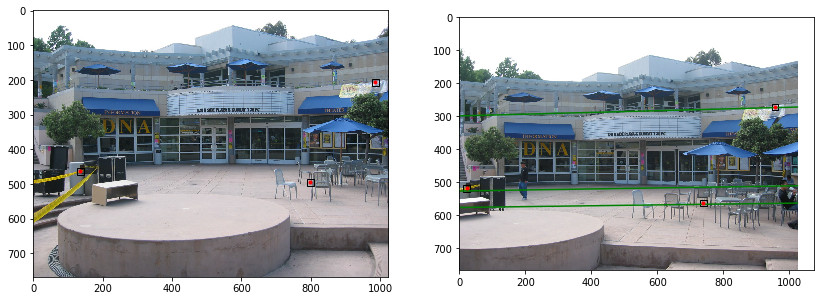

In [11]:
"""your code here"""
#Sample 3 distinct points
# idx = random.sample(list(outliers),3)
#Compute corresponding epipolar lines
idx = [126, 261, 178]
l = F_LM.dot(Homogenize(match1[:,idx]))
# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
print(idx)
for i in range(3):
    xx1 = match1[0,idx[i]]
    xx2 = match2[0,idx[i]]
    yy1 = match1[1,idx[i]]
    yy2 = match2[1,idx[i]]
    print(xx1, yy1)
    print(xx2, yy2)
    k = -1.0*l[0,i]/l[1,i]
    xx = np.linspace(0, I2.shape[1])
    yy = k*xx - 1.0*l[2,i]/l[1,i]
    ax1.plot(xx1, yy1,'.r')
    ax1.add_patch(patches.Rectangle((xx1-20/2,yy1-20/2),20,20, fill=False))
    ax2.plot(xx, yy,'-g')
    ax2.plot(xx2, yy2,'.r')
    ax2.add_patch(patches.Rectangle((xx2-20/2,yy2-20/2),20,20, fill=False))
plt.show()

## Problem 8 (Programming): Projective to Euclidean Reconstruction (15 points)

You are given a Matlab file containing points obtained from applying three-view geometry techniques (using the trifocal tensor) to obtain a projective reconstruction of points from a 3D scene. Also in the file are groundtruth control points. Compute the homography transformation using the DLT along with the projected 3D scene points and control points to upgrade the projective reconstruction to a Euclidean reconstruction. Render the scene, and comment on your results. What does the scene look like? (You may have to rotate the plot to get a better view.)


In [13]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

reconstruction = sio.loadmat('ereconstruction.mat')
X_projective = reconstruction['X_projective']
X_projective = X_projective.T
X_control = reconstruction['X_c']
X_control = X_control.T

H_DLT=
[[-4.05391050e-02  2.30511092e-03 -1.27864732e-03  5.31813688e-01]
 [-2.83214207e-03 -3.52507579e-02 -2.02718886e-03  7.56337034e-01]
 [-8.35206850e-05  9.21532140e-05 -3.86033901e-02  1.99655946e-02]
 [ 8.66741162e-06 -6.87943722e-06  2.88078962e-05  3.74612486e-01]]


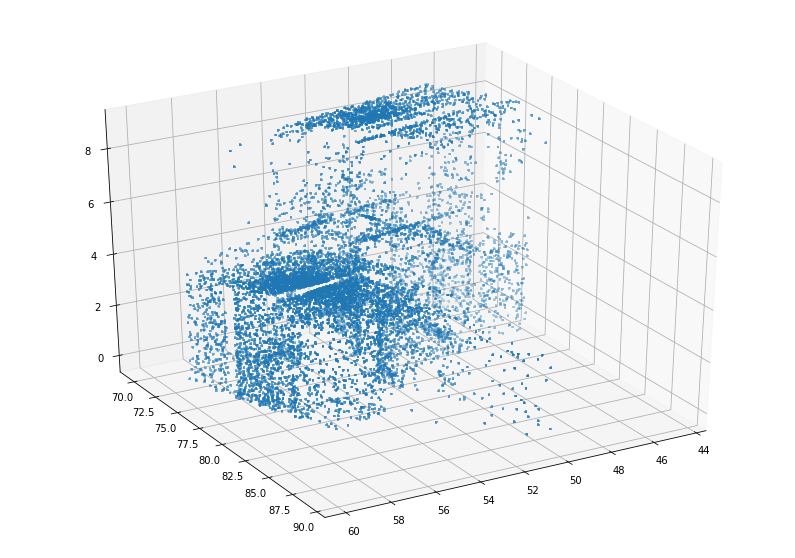

In [16]:
def LeftNullVector(x):
    # compute left null of x
    e = np.array([1]+[0]*(x.shape[1]-1))
    V = [np.mat(a + np.linalg.norm(a)*e) if a[0]>0 \
         else np.mat(a - np.linalg.norm(a)*e) \
         for a in x]
    I = np.eye(x.shape[1])
    H = np.array([I-2*(v.T*v)/(v*v.T) for v in V])
    return H[:,1:,:]

def ComputeHomography(Xp, Xc, normalize=True):
    """your code here"""
    if normalize:
        Xc, T = Normalize(Dehomogenize(Xc))
        X, U = Normalize(Dehomogenize(Xp[:,:6]))
    else:
        X = Homogenize(Dehomogenize(Xp[:,:6]))
        Xc= Homogenize(Dehomogenize(Xc))
    
    X, Xc = X.T, Xc.T
    Xc_leftnull = LeftNullVector(Xc)
    A = np.array([np.kron(Xc_leftnull[i],X[i]) for i in range(6)])
    A = A.reshape((A.shape[0]*A.shape[1],1, A.shape[2]))
    A = A.reshape((A.shape[0], A.shape[2]))
    
    _,_,VT = np.linalg.svd(A)
    h = VT[-1]
    H = np.mat(h.reshape((4,4)))
    if normalize:
        H /= H[3,3]
        H = np.matmul(np.matmul(np.linalg.inv(T),H),U)
    H = H/np.linalg.norm(H)
#     print(H)
    return H

H = ComputeHomography(X_projective, X_control, normalize = True)
print("H_DLT=")
print(H)
X_euclidean = H @ (X_projective)
X_euclidean = Dehomogenize(X_euclidean)
Xe, Ye, Ze = X_euclidean[0,:], X_euclidean[1,:], X_euclidean[2,:] 
fig = plt.figure(figsize=(14, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(elev=30., azim=60)
axis.scatter(Xe, Ye, Ze, marker="+", s=8)
plt.show()

#### Comments
The scene looks like a building with two major units.